## Predicting house prices in King County USA

In this notebook I want to explore some regression techniques, and see if we can find a model that best predicts house prices. 

We start off with some exploration of the data, I want to understand which relationships exist which will then inform feature creation/transformation and other modelling decisions. 

We will look into Linear Regression first, then move onto tree based methods. 

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from plotting.plotting import format_y_values, format_x_values

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/Users/rory.vigus/.virtualenvs/dev/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploring the dataset

In [2]:
df_master = pd.read_csv("kc_house_data.csv")
df_master = df_master.drop(labels=["id"], axis=1)

In [3]:
df = df_master.copy()

In [4]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,3,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650
1,20141209T000000,538000.000,3,2.250,2570,7242,2.000,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,20150225T000000,180000.000,2,1.000,770,10000,1.000,0,0,3,6,770,0,1933,0,98028,47.738,-122.233,2720,8062
3,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,5,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000
4,20150218T000000,510000.000,3,2.000,1680,8080,1.000,0,0,3,8,1680,0,1987,0,98074,47.617,-122.045,1800,7503


In [5]:
df.columns
# sqft_living15 = sqft of 15 nearest houses
# sqft_lot15 = sqft of 15 nearest houses

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

How are house prices distributed?

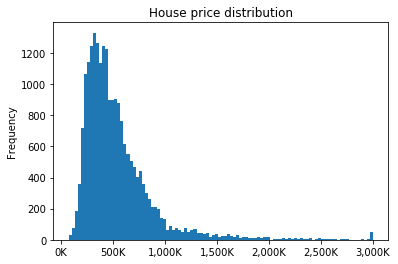

In [6]:
fig, ax = plt.subplots(1, 1)
np.clip(df["price"], 0, 3*10**6).plot(kind="hist", bins=100, ax=ax)
format_x_values(ax, format="K")
ax.set_title("House price distribution");

What are the correlations of variables that inutitively we would expect to influence price?

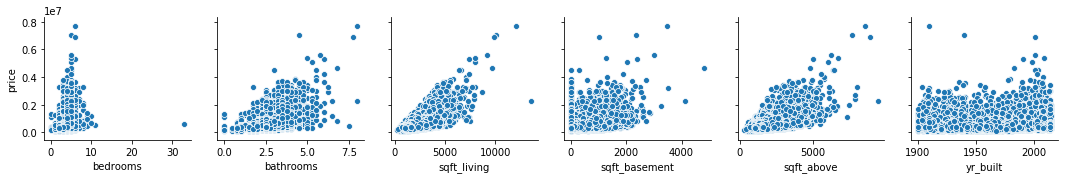

In [7]:
sns.pairplot(
    data=df, 
    x_vars=["bedrooms", "bathrooms", "sqft_living", "sqft_basement", "sqft_above", "yr_built", "sqft_living15", "sqft_lot15"], 
    y_vars=["price"]
);

What are the general distributions of our numeric features?

/Users/rory.vigus/.virtualenvs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


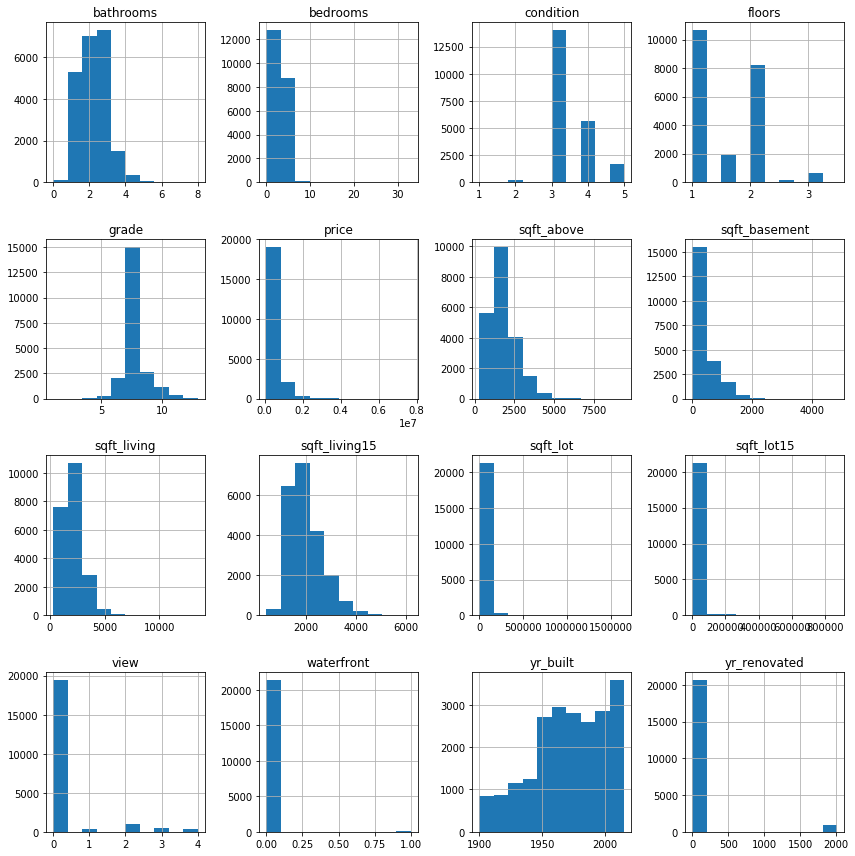

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
df.drop(labels=["lat", "long", "zipcode"], axis=1).hist(ax=ax);
plt.tight_layout()

What are the relationships between some of the categorical variables and price?

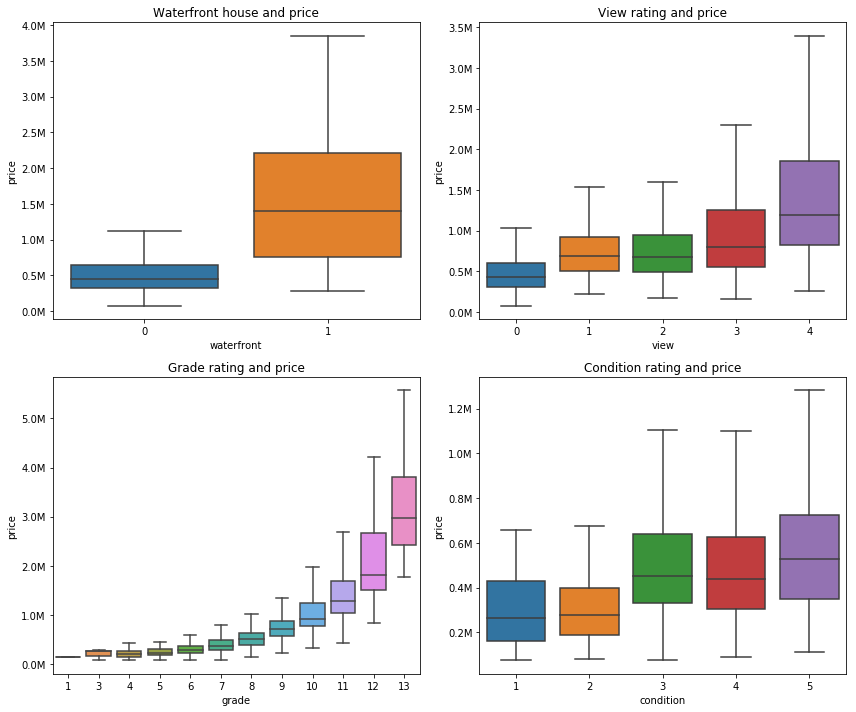

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
feature_cols = ["waterfront", "view", "grade", "condition"]
titles = ["Waterfront house and price", "View rating and price", "Grade rating and price", "Condition rating and price"]

for ax, feature, title in zip(axes.flat, feature_cols, titles):
    sns.boxplot(x=df[feature], y=df["price"], showfliers=False, ax=ax)
    ax.set_title(title)
    format_y_values(ax)

plt.tight_layout()

waterfront, view, condition can all be converted sensibibly into dummy variables. For grade, the relationship is quadratic and might be better expressed by including an grade^2 feature. 

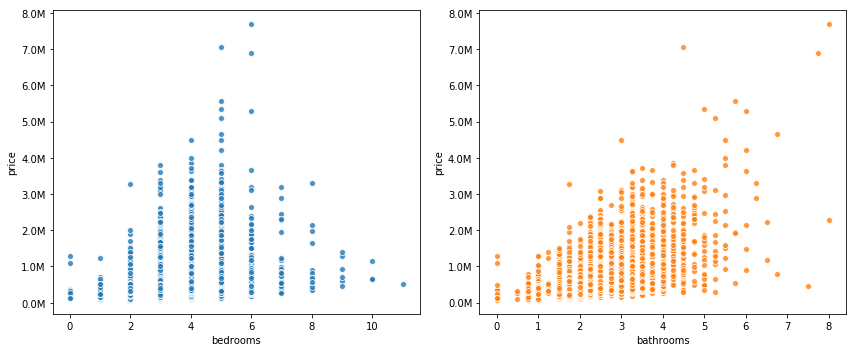

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
features = ["bedrooms", "bathrooms"]

for ax, feature in zip(axes.flat, features):        
    df_ = df[df["bedrooms"] < 30] # there is an outlier with more than 30 bedrooms.
    sns.regplot(x=df_[feature], y=df_["price"], ax=ax, scatter_kws={'edgecolor':'w'}, fit_reg=False)
    format_y_values(ax)

plt.tight_layout()

The relationship between price/bathrooms seems to be more informative than price/bedrooms. I.e it is more consistent that as you increase the number of bathrooms in a property, you also increase it's price.

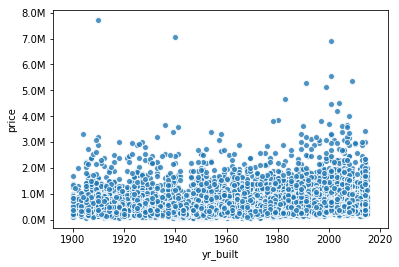

In [11]:
fig, ax = plt.subplots(1, 1)
sns.regplot(x=df["yr_built"], y=df["price"], ax=ax, fit_reg=False, scatter_kws={"edgecolor":"w"})
format_y_values(ax)

y_built is weakly correlated with property prices.

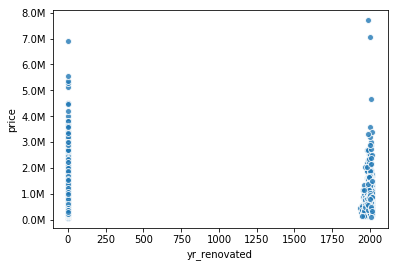

In [12]:
fig, ax = plt.subplots(1, 1)
sns.regplot(x=df["yr_renovated"], y=df["price"], ax=ax, fit_reg=False, scatter_kws={"edgecolor":"w"})
format_y_values(ax)

Lots of houses have not been renovated, perhaps we can turn this into a dummy, 1=rennovated, 0=not.

**Latitude/Longitude**

It would make sense to assume that the geographic location of the property will impact its price. In LR we cannot use lat/long coordinates directly, how do you express price in terms of unit change? Perhaps instead we can try to "discover" neighbourhoods via clustering. It's not a new problem, and a quick search suggests AgglomerativeClustering as a good method to use on lat/long coordinates. 

A new variable will be created assosciated with all most similar houses in terms of lattitude and longitude. 

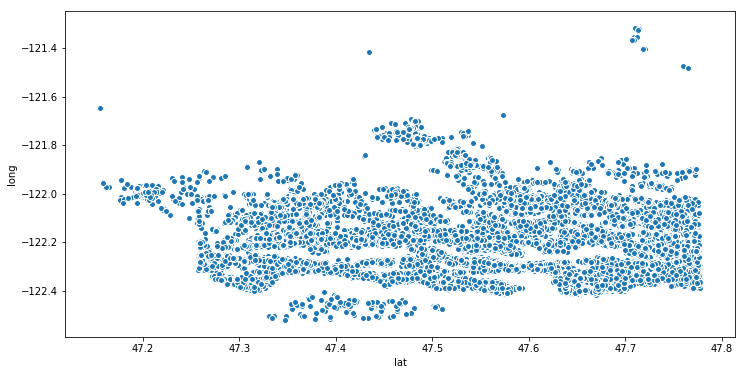

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.scatter(df["lat"], df["long"], edgecolor="w")
ax.set_xlabel("lat")
ax.set_ylabel("long");

In [14]:
from sklearn.cluster import AgglomerativeClustering

As we don't know how the neighbourhood lines are drawn, I think it makes sense to set this number very high and get lots of small groups, its then likely that these groups reflect accurately prices in there immediate area. If we have about 20k observations, and assuming 100 equally sized groups are created thats 200 samples per group. Which sounds suitable enough. 

In [15]:
agc = AgglomerativeClustering(
    n_clusters=100, 
    affinity="euclidean",
    linkage="ward"
)
cluster = agc.fit_predict(df[["lat", "long"]])

Text(0,0.5,'long')

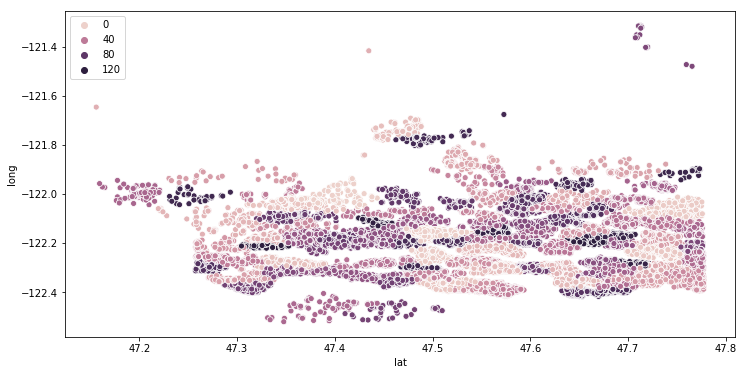

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x=df["lat"], y=df["long"], hue=cluster, ax=ax)
ax.set_xlabel("lat")
ax.set_ylabel("long")

Finally just a last check to see whether we can drop any highly correlated features, multicoliniarity can have a negative impact on the interpretation of model coeficients.

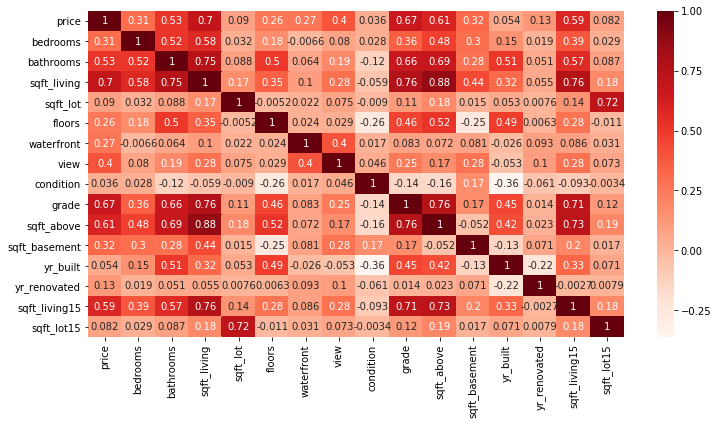

In [18]:
# Any highly correlated features?
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
corr = df.drop(labels=["date", "zipcode", "lat", "long"], axis=1).corr()
sns.heatmap(corr, ax=ax, annot=True, cmap=plt.cm.Reds)

## Datapipeline
Here we will define our datapipeline including any feature generation/transformations. We can then always get from the raw dataset to our modelling dataset. 

In [19]:
class Datapipeline(object):
    
    def __init__(self, df, drop_first_dummy=True):
        self.df = df
        self.drop_first_dummy = drop_first_dummy
    
    def grade_squared(self):
        ## Non linear relationship between grade and price
        self.df["grade_2"] = self.df["grade"] ** 2
        
    def generate_geo_clusters(self):
        """
        Will apply our clustering algorithm to lat/long co-ordinates
        
        """
        
        agc = AgglomerativeClustering(
            n_clusters=100, 
            affinity="euclidean",
            linkage="ward"
        )
        
        self.df["geo_cluster"] = agc.fit_predict(self.df[["lat", "long"]])
#         self.df = self.df.drop(labels=["lat", "long"], axis=1)
         
    def generate_dummies(self):
        """
        Defines all dummy variables to be created. 
        
        """
        
        # has_basement
        self.df["has_basement"] = np.where(self.df["sqft_basement"]>0, 1, 0)
        
        # is_renovated
        self.df["is_renovated"] = np.where(self.df["yr_renovated"]>0, 1, 0)
        self.df = self.df.drop(labels=["yr_renovated"], axis=1)
        
        # is_waterfront
        self.df["is_waterfront"] = np.where(self.df["waterfront"]==1, 1, 0)
        self.df = self.df.drop(labels=["waterfront"], axis=1)
        
        for col in ["condition", "view", "floors", "geo_cluster"]:
            if self.drop_first_dummy:
                dummies = pd.get_dummies(self.df[col], prefix=col, drop_first=True)
            else:
                dummies = pd.get_dummies(self.df[col], prefix=col, drop_first=True)
            
            self.df = pd.merge(left=self.df, right=dummies, left_index=True, right_index=True)
            self.df = self.df.drop(labels=[col], axis=1)
 
    def drop_unwanted_columns(self):
        """
        Clean up uneeded columns
        
        """
        
        self.df = self.df.drop(labels=["date", "zipcode"], axis=1)
            
    def run(self):
        self.grade_squared()
        self.generate_geo_clusters()
        self.generate_dummies()
        self.drop_unwanted_columns()
        
        return self.df

In [20]:
dp = Datapipeline(df, True)
df_m = dp.run()

In [21]:
df_m.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,grade_2,has_basement,is_renovated,is_waterfront,condition_2,condition_3,condition_4,condition_5,view_1,view_2,view_3,view_4,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,geo_cluster_10,geo_cluster_11,geo_cluster_12,geo_cluster_13,geo_cluster_14,geo_cluster_15,geo_cluster_16,geo_cluster_17,geo_cluster_18,geo_cluster_19,geo_cluster_20,geo_cluster_21,geo_cluster_22,geo_cluster_23,geo_cluster_24,geo_cluster_25,geo_cluster_26,geo_cluster_27,geo_cluster_28,geo_cluster_29,geo_cluster_30,geo_cluster_31,geo_cluster_32,geo_cluster_33,geo_cluster_34,geo_cluster_35,geo_cluster_36,geo_cluster_37,geo_cluster_38,geo_cluster_39,geo_cluster_40,geo_cluster_41,geo_cluster_42,geo_cluster_43,geo_cluster_44,geo_cluster_45,geo_cluster_46,geo_cluster_47,geo_cluster_48,geo_cluster_49,geo_cluster_50,geo_cluster_51,geo_cluster_52,geo_cluster_53,geo_cluster_54,geo_cluster_55,geo_cluster_56,geo_cluster_57,geo_cluster_58,geo_cluster_59,geo_cluster_60,geo_cluster_61,geo_cluster_62,geo_cluster_63,geo_cluster_64,geo_cluster_65,geo_cluster_66,geo_cluster_67,geo_cluster_68,geo_cluster_69,geo_cluster_70,geo_cluster_71,geo_cluster_72,geo_cluster_73,geo_cluster_74,geo_cluster_75,geo_cluster_76,geo_cluster_77,geo_cluster_78,geo_cluster_79,geo_cluster_80,geo_cluster_81,geo_cluster_82,geo_cluster_83,geo_cluster_84,geo_cluster_85,geo_cluster_86,geo_cluster_87,geo_cluster_88,geo_cluster_89,geo_cluster_90,geo_cluster_91,geo_cluster_92,geo_cluster_93,geo_cluster_94,geo_cluster_95,geo_cluster_96,geo_cluster_97,geo_cluster_98,geo_cluster_99
0,221900.000,3,1.000,1180,5650,7,1180,0,1955,47.511,-122.257,1340,5650,49,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,538000.000,3,2.250,2570,7242,7,2170,400,1951,47.721,-122.319,1690,7639,49,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.000,2,1.000,770,10000,6,770,0,1933,47.738,-122.233,2720,8062,36,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.000,4,3.000,1960,5000,7,1050,910,1965,47.521,-122.393,1360,5000,49,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,510000.000,3,2.000,1680,8080,8,1680,0,1987,47.617,-122.045,1800,7503,64,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Modelling

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

We want to create our train/validate/test sets -> we need to keep test as unseen data - validate will be used for manual parameter optimization, not implemented in CV methods in sklearn.

In [23]:
nobs = len(df_m)
train_pct = 0.6
val_pct = 0.2

# First shuffle the dataframe
# Then get split by index at 60% of data, and 80% of data. 
# Leaving with three splits. 0-60%, 60-80%=20%, 80-100%=20%.
train, validate, test = np.split(df_m.sample(frac=1, random_state=6), [int(.6*nobs), int(.8*nobs)])

for d in [train, validate, test]:
    print(np.round(len(d)*1.0/nobs, 2))

0.6
0.2
0.2


In [24]:
def get_x_y(data):
    X = data.drop(labels=["price"], axis=1)
    y = data["price"]
    return X, y

In [25]:
X_train, y_train = get_x_y(train)
X_val, y_val = get_x_y(validate)
X_test, y_test = get_x_y(test)

In [26]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,grade_2,has_basement,is_renovated,is_waterfront,condition_2,condition_3,condition_4,condition_5,view_1,view_2,view_3,view_4,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,geo_cluster_10,geo_cluster_11,geo_cluster_12,geo_cluster_13,geo_cluster_14,geo_cluster_15,geo_cluster_16,geo_cluster_17,geo_cluster_18,geo_cluster_19,geo_cluster_20,geo_cluster_21,geo_cluster_22,geo_cluster_23,geo_cluster_24,geo_cluster_25,geo_cluster_26,geo_cluster_27,geo_cluster_28,geo_cluster_29,geo_cluster_30,geo_cluster_31,geo_cluster_32,geo_cluster_33,geo_cluster_34,geo_cluster_35,geo_cluster_36,geo_cluster_37,geo_cluster_38,geo_cluster_39,geo_cluster_40,geo_cluster_41,geo_cluster_42,geo_cluster_43,geo_cluster_44,geo_cluster_45,geo_cluster_46,geo_cluster_47,geo_cluster_48,geo_cluster_49,geo_cluster_50,geo_cluster_51,geo_cluster_52,geo_cluster_53,geo_cluster_54,geo_cluster_55,geo_cluster_56,geo_cluster_57,geo_cluster_58,geo_cluster_59,geo_cluster_60,geo_cluster_61,geo_cluster_62,geo_cluster_63,geo_cluster_64,geo_cluster_65,geo_cluster_66,geo_cluster_67,geo_cluster_68,geo_cluster_69,geo_cluster_70,geo_cluster_71,geo_cluster_72,geo_cluster_73,geo_cluster_74,geo_cluster_75,geo_cluster_76,geo_cluster_77,geo_cluster_78,geo_cluster_79,geo_cluster_80,geo_cluster_81,geo_cluster_82,geo_cluster_83,geo_cluster_84,geo_cluster_85,geo_cluster_86,geo_cluster_87,geo_cluster_88,geo_cluster_89,geo_cluster_90,geo_cluster_91,geo_cluster_92,geo_cluster_93,geo_cluster_94,geo_cluster_95,geo_cluster_96,geo_cluster_97,geo_cluster_98,geo_cluster_99
18274,5,1.750,3000,6000,7,1500,1500,1958,47.492,-122.225,2230,7125,49,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20145,5,2.750,2481,4045,8,2481,0,2014,47.260,-122.284,2363,4175,64,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1594,3,1.750,1620,4200,7,830,790,1945,47.674,-122.285,1580,5000,49,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15004,3,1.000,1980,8505,7,1030,950,1965,47.538,-122.353,1830,8505,49,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16285,4,2.750,3260,4900,9,3260,0,2013,47.481,-122.123,3260,6132,81,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
def get_performance(y_true, preds, print_mode=False):
    mae = mean_absolute_error(y_true, preds)
    mse = mean_squared_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    
    if print_mode:
        print(f"MAE: {mae}")
        print(f"MSE: {mse}")
        print(f"R^2: {r2}")
    else:
        return mae, mse, r2
    
def plot_residuals(y_true, preds, ax):
    sns.scatterplot(preds, y_true-preds, ax=ax)
    ax.set_ylabel("residuals")
    ax.set_xlabel("predictions")
    format_y_values(ax, format="K")
    format_x_values(ax, format="K")

In [28]:
# Fit a simple model - using only sqft_living.|
lin_reg_simple = LinearRegression()
lin_reg_simple.fit(X_train["sqft_living"].values.reshape(-1, 1), y_train)
lin_reg_simple_preds = lin_reg_simple.predict(X_val["sqft_living"].values.reshape(-1, 1))

get_performance(y_val, lin_reg_simple_preds, print_mode=True)

MAE: 174698.11252763413
MSE: 67512308644.35545
R^2: 0.47342840147740883


In [29]:
# Fit a model using all features
lin_reg = LinearRegression()
lin_reg.fit(X_train.drop(labels=["lat", "long"], axis=1), y_train);
lin_reg_preds = lin_reg.predict(X_val.drop(labels=["lat", "long"], axis=1))

get_performance(y_val, lin_reg_preds, print_mode=True)

MAE: 90190.51966170558
MSE: 22088548393.898197
R^2: 0.8277173085860537


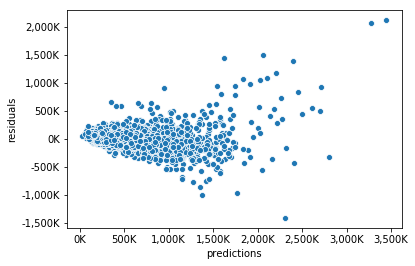

In [30]:
fig, ax = plt.subplots(1, 1)
plot_residuals(y_val, lin_reg_preds, ax=ax)

We are under-predicting high priced homes. (residuals = y_true - preds).

Also the MAE is quite large, that has something to do with the fact that we are getting higher priced homes incorrect more than lower priced homes, and this is skewing our accuracy metrics.

Potentially we can try and fix the skewed price distribution by taking the log(price). Logging will in essence reduce the variability in prices, and bring outliers more inline with the rest of the data. Transforming the predictions back to dollar amounts can be achieved by inversing the log transformation.

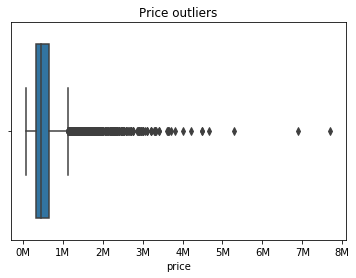

In [31]:
fig, ax1 = plt.subplots(1, 1)
sns.boxplot(y_train, ax=ax1)
format_x_values(ax1, format="M")
ax1.set_title("Price outliers");

Text(0.5,1,'log(y)')

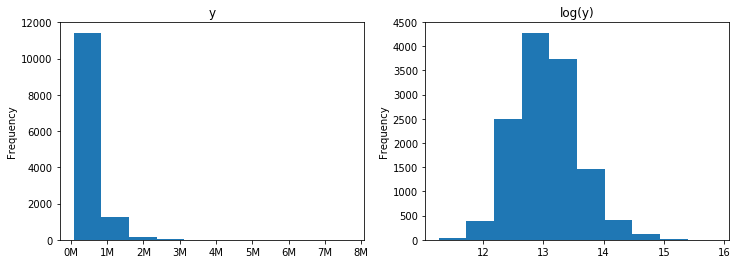

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
y_train.plot(kind="hist", ax=ax1)
format_x_values(ax1, format="M")
np.log(y_train).plot(kind="hist", ax=ax2)
ax1.set_title("y")
ax2.set_title("log(y)")

In [33]:
# Fit a model using log(target)
lin_reg_log = LinearRegression()
lin_reg_log.fit(X_train.drop(labels=["lat", "long"], axis=1), np.log(y_train));
lin_reg_log_preds = lin_reg_log.predict(X_val.drop(labels=["lat", "long"], axis=1))

print(r2_score(np.log(y_val), lin_reg_log_preds))
print(mean_absolute_error(y_val, np.exp(lin_reg_log_preds)))

0.8805941859909108
73274.33012568088


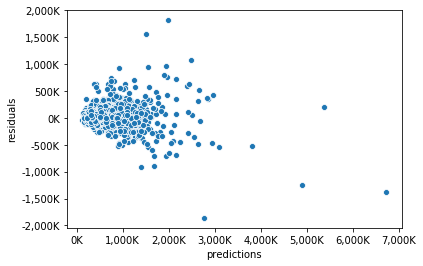

In [34]:
fig, ax = plt.subplots(1, 1)
plot_residuals(y_val, np.exp(lin_reg_log_preds), ax=ax)

We can see we have improved model fit, R2=0.88, our MAE is better by 20k, and we have improved the shape of our residuals. It's still not perfect and we have some errornous predictions of higher priced homes. Lets see if we can make any further improvements with a different type of model. 

In [66]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [67]:
# Lattitude/Longitude data can be handled with tree models. We can remove the geo_clusters dummies. 
cols = [c for c in X_train.columns if "geo_cluster" not in c]

In [68]:
rand_for = RandomForestRegressor()
rand_for.fit(X_train[cols], y_train)
rand_preds = rand_for.predict(X_val[cols])
print(mean_absolute_error(y_val, rand_preds))

70994.67390633159


This is already an improvement on our LR model. Out of interest which features are most informative in the RandomForest?

In [69]:
importances_ = pd.Series(rand_for.feature_importances_, X_train[cols].columns).sort_values(ascending=False)
print(importances_[:15])

sqft_living     0.253
grade_2         0.162
grade           0.157
lat             0.157
long            0.072
sqft_living15   0.034
bathrooms       0.032
sqft_above      0.027
is_waterfront   0.026
yr_built        0.025
sqft_lot        0.014
sqft_lot15      0.013
sqft_basement   0.006
view_4          0.005
bedrooms        0.004
dtype: float64


Another ensemble method that utilizes DecisionTrees is GradientBoosting. An ensemble in this case is a sequential set of weak-models, each trying to correct the error from its predecessor. 

In [52]:
gbr_mod = GradientBoostingRegressor()
gbr_mod.fit(X_train[cols], y_train)
gbr_preds = gbr_mod.predict(X_val[cols])
print(mean_absolute_error(y_val, gbr_preds))

79131.92571670326


Ok so by default, RandomForest is out on top + no transformation needs to be done for the lattitude/longitude features, which I think is quite powerful. 

I wonder if we can improve these models with some hyperparameter tuning. 

One approach I have found to be effective is to first perform a randomized grid search over a range of parameters. The result of this gives us a starting point for a final exhaustive grid search over a narrower range of parameters. 

I keep n_estimators fixed at a high-ish amount, as generally speaking the higher this number, the better the fit will be. Learning rate also is kept at 0.05. The lower the rate, the higher the number of estimators needs to be to get a good model fit. 

In [43]:
# This takes about 45mins.
param_grid = {
    "max_depth":np.arange(1, 21, step=1),
    "min_samples_split":np.arange(start=2, stop=50, step=2),
    "min_samples_leaf":np.arange(start=2, stop=50, step=2),
    "max_features": ["auto", "sqrt"]
}

grid = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(n_estimators=500, learning_rate=0.05),
    param_distributions=param_grid, 
    n_iter=100,
    cv=3,
    n_jobs=-1
)
grid.fit(X_train[cols], y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.05,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [46]:
gbr_best_est_1 = grid.best_estimator_
print(gbr_best_est_1)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=6,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=40,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [47]:
gbr_best_est_1.fit(X_train[cols], y_train)
print(mean_absolute_error(y_val, gbr_best_est_1.predict(X_val[cols])))

68170.9811962765


In [70]:
# I had already configured the initial grid with low steps (+1, +2), and the optimal params fall safely inside these ranges. 
# So we can be quite confident these are optimal. We can tune min_samples_leaf a final time +-1 around the optimal parameter from the intiial search.
# I am also going to boost the n_estimators here and this will form our final model.

param_grid = {"min_samples_leaf":[5, 6, 7]}
grid_ex = GridSearchCV(
    estimator=GradientBoostingRegressor(
        n_estimators=1000, 
        learning_rate=0.05, 
        max_depth=6, 
        max_features="sqrt", 
        min_samples_split=40
    ),
    param_grid=param_grid
)

grid_ex.fit(X_train[cols], y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.05,
                                                 loss='ls', max_depth=6,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=40,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000,
                                                 n_iter_no_change=None,
         

In [71]:
gbr_best_est_2 = grid_ex.best_estimator_
print(gbr_best_est_2)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=6,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=7, min_samples_split=40,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [72]:
gbr_best_est_2.fit(X_train[cols], y_train)
print(mean_absolute_error(y_val, gbr_best_est_2.predict(X_val[cols])))

65849.16273523353


Ok, so we have been able to improve GBR by a 14k difference to MAE. What about RandomForest?

In [81]:
max_depth = list(np.arange(1, 21, step=1))
max_depth.append(None)
min_samples_split = np.arange(2, 50, 2)
min_samples_leaf = np.arange(1, 50, 2)

param_grid = {
    "max_depth":max_depth,
    "min_samples_split":min_samples_split,
    "min_samples_leaf":min_samples_leaf,
    "max_features": ["auto", "sqrt"]
}

grid_rand_f = RandomizedSearchCV(
    estimator=RandomForestRegressor(n_estimators=100),
    param_distributions=param_grid, 
    n_iter=100,
    cv=3,
    n_jobs=-1
)
grid_rand_f.fit(X_train[cols], y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [83]:
best_est_rand_1 = grid_rand_f.best_estimator_
print(best_est_rand_1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


Can we determine the benefit to MAE by additional estimators?

In [87]:
val_mae = []
ind = np.arange(100, 500, 10)

for i in ind:
    mod = RandomForestRegressor(n_estimators=i, max_depth=15, min_samples_split=10, min_samples_leaf=3, n_jobs=-1)
    mod.fit(X_train[cols], y_train)
    val_mae.append(mean_absolute_error(y_val, mod.predict(X_val[cols])))    

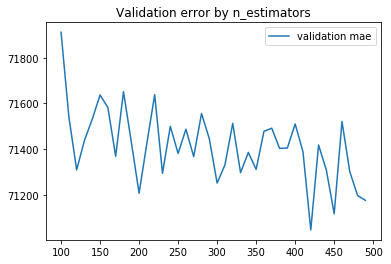

In [96]:
fig, ax = plt.subplots(1, 1)
ax.plot(ind, val_mae, label="validation mae")
ax.set_title("Validation error by n_estimators")
ax.legend();

We get marginally better models after around 200 estimators. The trade off between training time and accuracy in this case isn't too bad as we have a small dataset. For large datasets we might decide the tradeoff isn't worth it. 

In [97]:
best_rand_est = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=10, min_samples_leaf=3, n_jobs=-1)
best_rand_est.fit(X_train[cols], y_train)
print(mean_absolute_error(y_val, best_rand_est.predict(X_val[cols])))

71373.54623012248


**Taking both models on X_test**

In [99]:
for mod in [best_rand_est, gbr_best_est_2]:
    print(type(mod).__name__)
    print(mean_absolute_error(y_test, mod.predict(X_test[cols])))   
    print()

RandomForestRegressor
72533.74303501457

GradientBoostingRegressor
66208.10486157416



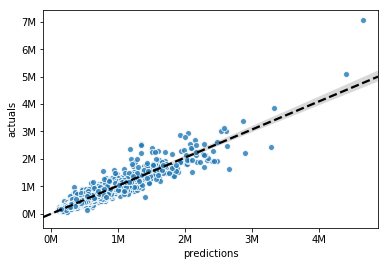

In [107]:
preds = gbr_best_est_2.predict(X_test[cols])
fig, ax = plt.subplots(1, 1)
sns.regplot(preds, y_test, scatter_kws={"edgecolor":"w"}, line_kws={"ls":"--", "color":"k"}, ax=ax)
ax.set_ylabel("actuals")
ax.set_xlabel("predictions")
format_y_values(ax, format="M")
format_x_values(ax, format="M")

### Summary

In this notebook we explored two model types - Linear Regression and Tree based ensemble methods (GradientBoosting, RandomForest), with the goal of building a model able to predict house prices in kings-county USA.

We tried some simple ideas to return the maximum accuracy possible from these models.
* With LinearRegression we were able to move from an MAE of 170k down to 73k via some feature transformations, and sensible feature creation.
* We were then able to improve this further using Tree based methods. We moved a basic GBR model from an MAE of 79k down to 66k, following some hyperparameter tuning.


To improve on:
* We did not explore feature ranking - i.e do we really need all features to achieve decent results.
* We did not explore interaction terms between features, how does one feature move with another? Can we capture that effect.
* We did not explore much the impact of outliers, and whether there was anything we could have done to stabilize predictions at the higher priced range. 